In [1]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec
/kaggle/input/movies/IMDB Dataset.csv
/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

2024-05-06 21:08:02.777190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 21:08:02.777285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 21:08:02.873209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df=pd.read_csv('/kaggle/input/movies/IMDB Dataset.csv')

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
#le dataset contient 50000 lignes et 2 colonnes
df.shape

(50000, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
#the dataset doesn't have any null values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
df.iloc[3,:]['review'],df.iloc[3,:]['sentiment']

("Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",
 'negative')

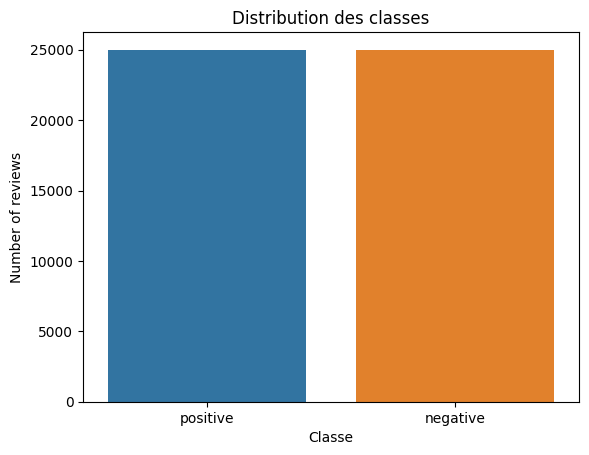

In [10]:
sns.countplot(x='sentiment', data=df)
plt.title('Distribution des classes')
plt.xlabel('Classe')
plt.ylabel('Number of reviews')
plt.show()

The count plot shows that we have a balanced dataset, 25000 for the positive reviews and 25000 for the negative reviews

## preprocessing

In [7]:
def preprocess_text(sen):
 # Removing html tags
 sentence = remove_tags(sen)
 # Remove punctuations and numbers
 sentence = re.sub('[^a-zA-Z]', ' ', sentence)
 # Single character removal
 sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
 # Removing multiple spaces
 sentence = re.sub(r'\s+', ' ', sentence)
 return sentence

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
 return TAG_RE.sub('', text)
def normalize_text(df):
  df["review"]=df["review"].apply(lambda text : preprocess_text(text))
  df["review"]=df["review"].apply(lambda text : remove_tags(text))
  return df
df = normalize_text(df)

In [8]:
X=df['review']

In [9]:
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [21]:
def plot_results(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

# Word embedding : Glove 

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [12]:

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train_padded = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open("/kaggle/input/glove6b100dtxt/glove.6B.100d.txt", encoding="utf8")
for line in glove_file:
 records = line.split()
 word = records[0]
 vector_dimensions = asarray(records[1:],dtype='float32')
 embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
 embedding_vector = embeddings_dictionary.get(word)
 if embedding_vector is not None:
  embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

#### flatten + sigmoid 

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Define the model
model_glove = Sequential()

# Add the Embedding layer
model_glove.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Add the Flatten layer
model_glove.add(Flatten())

# Add the Dense layer
model_glove.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model_glove.summary()

In [ ]:
history_glove = model_glove.fit(X_test_padded, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

In [ ]:
score = model_glove.evaluate(X_test_padded, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_glove)

The accuracy on the training set is around 79% while on the validation set is around 49% =>the model is overfitting the data. Additionally , the model is underfitting the data as it is not performing well on the train set

#### CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model_cnn_glove = Sequential()

# Add the Embedding layer
model_cnn_glove.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

# Add the Convolutional layer
model_cnn_glove.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Add the MaxPooling layer
model_cnn_glove.add(MaxPooling1D())

# Add a Flatten layer
model_cnn_glove.add(Flatten())

# Add the Dense output layer
model_cnn_glove.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_cnn_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model_cnn_glove.summary()

In [ ]:
# Train the model
history_cnn_glove = model_cnn_glove.fit(X_train_padded, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

In [ ]:
score = model_cnn_glove.evaluate(X_test_padded, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_cnn_glove)

#### The accuracy on the training set is around 99% while on the validation set is around 85% =>the model is overfitting the data. However , using the CNN the model is performing well on the trainset

#### LSTM

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2

# Define the model
model_lstm_glove = Sequential()

# Add the Embedding layer
model_lstm_glove.add(Embedding(vocab_size, 100, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen))

# Add the LSTM layer with dropout and regularization
model_lstm_glove.add(LSTM(units=128, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))

# Add a Dropout layer after LSTM
model_lstm_glove.add(Dropout(0.5))

# Add the Dense output layer
model_lstm_glove.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_lstm_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model_lstm_glove.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 9372077 (35.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Train the model
history_lstm_glove = model_lstm_glove.fit(X_train_padded, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 61s 235ms/step - loss: 1.0377 - accuracy: 0.6397 - val_loss: 0.5390 - val_accuracy: 0.7814
Epoch 2/6
250/250 [==============================] - 51s 203ms/step - loss: 0.5066 - accuracy: 0.8008 - val_loss: 0.4767 - val_accuracy: 0.8080
Epoch 3/6
250/250 [==============================] - 47s 187ms/step - loss: 0.4228 - accuracy: 0.8457 - val_loss: 0.4138 - val_accuracy: 0.8512
Epoch 4/6
250/250 [==============================] - 45s 180ms/step - loss: 0.3625 - accuracy: 0.8768 - val_loss: 0.4131 - val_accuracy: 0.8549
Epoch 5/6
250/250 [==============================] - 45s 179ms/step - loss: 0.3197 - accuracy: 0.8972 - val_loss: 0.3996 - val_accuracy: 0.8540
Epoch 6/6
250/250 [==============================] - 44s 177ms/step - loss: 0.2777 - accuracy: 0.9144 - val_loss: 0.4035 - val_accuracy: 0.8540


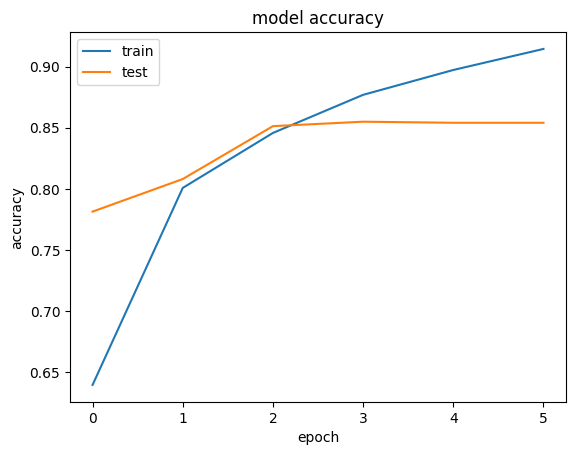

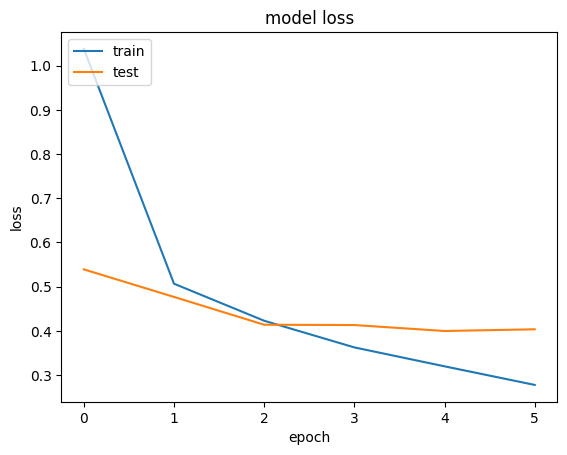

In [22]:
plot_results(history_lstm_glove)

In [23]:
score = model_lstm_glove.evaluate(X_test_padded, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 9s 28ms/step - loss: 0.3917 - accuracy: 0.8584
Test Score: 0.3916904926300049
Test Accuracy: 0.8583999872207642


The accuracy on the training set is around 99% while on the validation set is around 83% =>the model is overfitting the data. However , using LSTM architecture the model is performing well on the trainset

In [42]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import numpy as np

review = "This movie was absolutely fantastic! The acting was superb and the plot kept me on the edge of my seat."

encoded_review = tokenizer.texts_to_sequences([review])
# Pad the encoded review
maxlen = 100
padded_review = pad_sequences(encoded_review, padding='post', maxlen=maxlen)
predicted_probs = model_lstm_glove.predict(padded_review)
print(predicted_probs[0][0])
# Use argmax to determine the sentiment label
sentiment_label = "Positive" if predicted_probs[0][0] >= 0.5 else "Negative"

print("Predicted sentiment for the review:", sentiment_label)


1/1 [==============================] - 0s 42ms/step
0.7549234
Predicted sentiment for the review: Positive


#### CNN + GRU

In [34]:
# Define GRU Model
model_gru_glove = Sequential()
model_gru_glove.add(Embedding(vocab_size, 100,weights=[embedding_matrix], trainable=False))
model_gru_glove.add(GRU(128))
model_gru_glove.add(Dense(1, activation='sigmoid'))
model_gru_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
history_gru_glove = model_gru_glove.fit(X_train_padded, y_train, batch_size=128, epochs=6, validation_split=0.1)


Epoch 1/6
282/282 [==============================] - 5s 9ms/step - loss: 0.5261 - acc: 0.7274 - val_loss: 0.4300 - val_acc: 0.8025
Epoch 2/6
282/282 [==============================] - 2s 7ms/step - loss: 0.3893 - acc: 0.8256 - val_loss: 0.3574 - val_acc: 0.8370
Epoch 3/6
282/282 [==============================] - 2s 7ms/step - loss: 0.3571 - acc: 0.8402 - val_loss: 0.3686 - val_acc: 0.8393
Epoch 4/6
282/282 [==============================] - 2s 7ms/step - loss: 0.3323 - acc: 0.8530 - val_loss: 0.3563 - val_acc: 0.8397
Epoch 5/6
282/282 [==============================] - 2s 7ms/step - loss: 0.3124 - acc: 0.8630 - val_loss: 0.3450 - val_acc: 0.8418
Epoch 6/6
282/282 [==============================] - 2s 8ms/step - loss: 0.2955 - acc: 0.8713 - val_loss: 0.3180 - val_acc: 0.8590


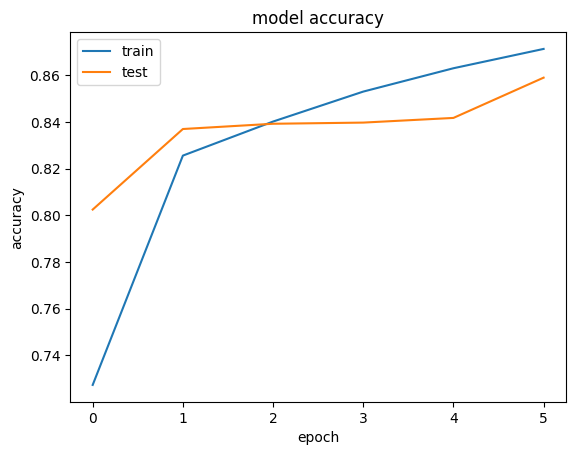

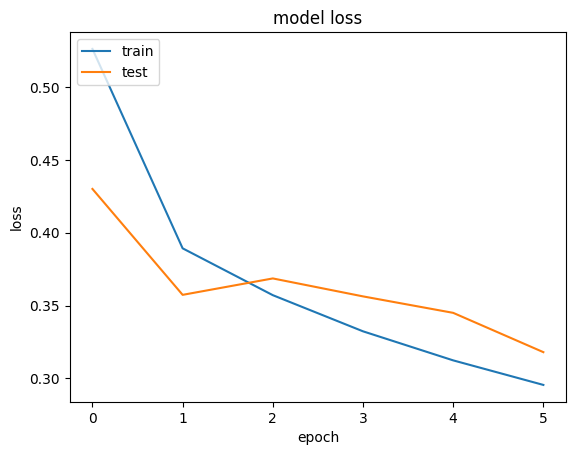

In [36]:
plot_results(history_gru_glove)

In [37]:
score = model_lstm_glove.evaluate(X_test_padded, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 9s 27ms/step - loss: 0.6124 - acc: 0.8467
Test Score: 0.6123842000961304
Test Accuracy: 0.8467000126838684


RNN + CNN

In [38]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

model_rnn_cnn_glove = Sequential()
model_rnn_cnn_glove.add(Embedding(len(tokenizer.word_index) + 1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_rnn_cnn_glove.add(SimpleRNN(64, return_sequences=True))
model_rnn_cnn_glove.add(Conv1D(64, 3, activation='relu'))
model_rnn_cnn_glove.add(GlobalMaxPooling1D())
# model_rnn_cnn_word2vec.add(Flatten())
model_rnn_cnn_glove.add(Dense(units=1, activation='sigmoid'))
model_rnn_cnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn_cnn_glove.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         9254700   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          10560     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9277677 (35.39 MB)
Trainable params: 22977 (89.75 KB)
Non-trainable params: 9254700 (35.30 MB)
___________

In [39]:
history_rnn_cnn_glove = model_rnn_cnn_glove.fit(X_train_padded, y_train, batch_size=64, epochs=6, validation_split=0.1)

Epoch 1/6
563/563 [==============================] - 39s 65ms/step - loss: 0.4899 - acc: 0.7574 - val_loss: 0.4420 - val_acc: 0.7920
Epoch 2/6
563/563 [==============================] - 36s 64ms/step - loss: 0.3853 - acc: 0.8242 - val_loss: 0.3718 - val_acc: 0.8340
Epoch 3/6
563/563 [==============================] - 36s 64ms/step - loss: 0.3473 - acc: 0.8478 - val_loss: 0.3670 - val_acc: 0.8385
Epoch 4/6
563/563 [==============================] - 36s 64ms/step - loss: 0.3231 - acc: 0.8596 - val_loss: 0.3532 - val_acc: 0.8460
Epoch 5/6
563/563 [==============================] - 36s 64ms/step - loss: 0.2991 - acc: 0.8726 - val_loss: 0.3506 - val_acc: 0.8447
Epoch 6/6
563/563 [==============================] - 36s 64ms/step - loss: 0.2773 - acc: 0.8832 - val_loss: 0.3535 - val_acc: 0.8470


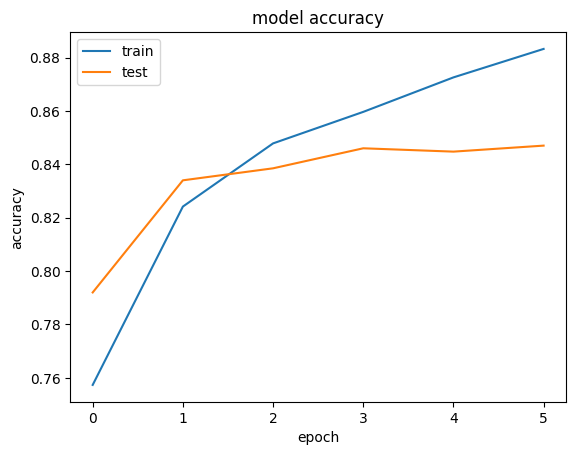

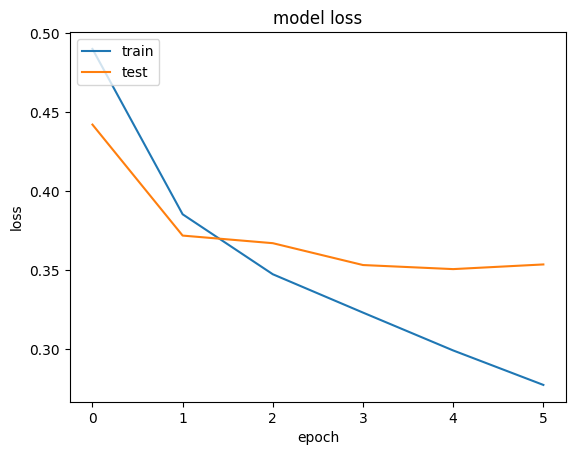

In [40]:
plot_results(history_rnn_cnn_glove)

In [41]:
score = model_rnn_cnn_glove.evaluate(X_test_padded, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 3s 9ms/step - loss: 0.3645 - acc: 0.8385
Test Score: 0.3644760549068451
Test Accuracy: 0.8385000228881836


## word embedding : Word2vec 

In [42]:
import gensim.downloader as api
from gensim.models import KeyedVectors


# Download the Google News Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin', binary=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [43]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_len = 300  # or use a fixed size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


AttributeError: 'int' object has no attribute 'lower'

In [ ]:
len(tokenizer.word_index) + 1

In [ ]:
# Create an embedding matrix
vocab_size=len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            continue

#### LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D
from keras.initializers import Constant

# Define LSTM Model
model_lstm_word2vec = Sequential()
model_lstm_word2vec.add(Embedding(len(tokenizer.word_index) + 1, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_lstm_word2vec.add(LSTM(128))
model_lstm_word2vec.add(Dense(1, activation='sigmoid'))
model_lstm_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history_lstm_word2vec = model_lstm_word2vec.fit(X_train_pad, y_train, batch_size=64, epochs=10, validation_split=0.1)


In [ ]:
score = model_lstm_word2vec.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
def plot_results(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

In [ ]:
plot_results(history_lstm_word2vec)

the LSTM model with Word2Vec showed good results on the training set and on the validation and test set

#### GRU

In [ ]:
# Define GRU Model
model_gru_word2vec = Sequential()
model_gru_word2vec.add(Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_gru_word2vec.add(GRU(128))
model_gru_word2vec.add(Dense(1, activation='sigmoid'))
model_gru_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history_gru_word2vec = model_gru_word2vec.fit(X_train_pad, y_train, batch_size=64, epochs=6, validation_split=0.1)


In [ ]:
score = model_gru_word2vec.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_gru_word2vec)

the GRU model trained with 10 epochs showed good results on the training set , but we remark that it has over learnt the data resulting in an overfitting 

#### RNN + CNN

In [ ]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

model_rnn_cnn_word2vec = Sequential()
model_rnn_cnn_word2vec.add(Embedding(len(tokenizer.word_index) + 1, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_rnn_cnn_word2vec.add(SimpleRNN(64, return_sequences=True))
model_rnn_cnn_word2vec.add(Conv1D(64, 3, activation='relu'))
model_rnn_cnn_word2vec.add(GlobalMaxPooling1D())
# model_rnn_cnn_word2vec.add(Flatten())
model_rnn_cnn_word2vec.add(Dense(units=1, activation='sigmoid'))
model_rnn_cnn_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn_cnn_word2vec.summary()


In [ ]:
history_cnn_rnn_word2vec = model_rnn_cnn_word2vec.fit(X_train_pad, y_train, batch_size=128, epochs=5, validation_split=0.1)


In [ ]:
score = model_rnn_cnn_word2vec.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_cnn_rnn_word2vec)

With this model , we remark that the more we go with epochs the gap between the validation accuracy and train accuracy increases which tells that there is a potential overfitting is about to happen with more epochs

# FastText embedding

In [ ]:
import gensim.downloader

# Download FastText model
fasttext_model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_len = 300  # or use a fixed size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Create an embedding matrix
vocab_size=len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        try:
            embedding_vector = fasttext_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Words not found in the embedding index will be all-zeros.
            continue

#### LSTM

In [ ]:

# Define LSTM Model
model_lstm_fasttext = Sequential()
model_lstm_fasttext.add(Embedding(len(tokenizer.word_index) + 1, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_lstm_fasttext.add(LSTM(128))
model_lstm_fasttext.add(Dense(1, activation='sigmoid'))
model_lstm_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_fasttext.summary()

In [ ]:
history_lstm_fasttext = model_lstm_fasttext.fit(X_train_pad, y_train, batch_size=64, epochs=6, validation_split=0.1)

In [ ]:
score = model_lstm_fasttext.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_lstm_fasttext)

#### GRU

In [ ]:
# Define LSTM Model
model_gru_fasttext = Sequential()
model_gru_fasttext.add(Embedding(len(tokenizer.word_index) + 1, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_gru_fasttext.add(GRU(128))
model_gru_fasttext.add(Dense(1, activation='sigmoid'))
model_gru_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru_fasttext.summary()

In [ ]:
history_gru_fasttext = model_gru_fasttext.fit(X_train_pad, y_train, batch_size=64, epochs=6, validation_split=0.1)

In [ ]:
score = model_gru_fasttext.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_gru_fasttext)

#### CNN+RNN

In [ ]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

model_rnn_cnn_fasttext = Sequential()
model_rnn_cnn_fasttext.add(Embedding(len(tokenizer.word_index) + 1, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_rnn_cnn_fasttext.add(SimpleRNN(64, return_sequences=True))
model_rnn_cnn_fasttext.add(Conv1D(64, 3, activation='relu'))
model_rnn_cnn_fasttext.add(GlobalMaxPooling1D())
# model_rnn_cnn_word2vec.add(Flatten())
model_rnn_cnn_fasttext.add(Dense(units=1, activation='sigmoid'))
model_rnn_cnn_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn_cnn_fasttext.summary()

In [ ]:
history_cnn_rnn_fasttext = model_rnn_cnn_fasttext.fit(X_train_pad, y_train, batch_size=128, epochs=6, validation_split=0.1)

In [ ]:
score = model_rnn_cnn_fasttext.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_results(history_cnn_rnn_fasttext)

# TF-IDF Word embedding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
tfidf_matrix = tfidf_matrix.toarray()

In [ ]:
tfidf_matrix.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

#### LSTM

In [ ]:
from keras.layers import Reshape
from keras.callbacks import EarlyStopping

model_lstm_tfidf = Sequential()
model_lstm_tfidf.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_lstm_tfidf.add(Reshape((64, 1)))
model_lstm_tfidf.add(LSTM(128,input_shape=(X_train.shape[1],)))
model_lstm_tfidf.add(Dense(1, activation='sigmoid'))
model_lstm_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



In [ ]:
history_lstm_tfidf = model_lstm_tfidf.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping], validation_data=(X_test, y_test))

In [ ]:
plot_results(history_lstm_tfidf)

In [ ]:
score = model_lstm_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

#### CNN+RNN

In [ ]:
from keras.regularizers import l2

model_cnn_rnn_tfidf = Sequential()
model_cnn_rnn_tfidf.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
model_cnn_rnn_tfidf.add(Reshape((64, 1)))
model_cnn_rnn_tfidf.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_rnn_tfidf.add(MaxPooling1D())
model_cnn_rnn_tfidf.add(SimpleRNN(units=128))
model_cnn_rnn_tfidf.add(Flatten())
model_cnn_rnn_tfidf.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_cnn_rnn_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history_cnn_rnn_tfidf = model_cnn_rnn_tfidf.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping], validation_data=(X_test, y_test))

In [ ]:
plot_results(history_cnn_rnn_tfidf)

In [ ]:
score = model_cnn_rnn_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

#### GRU

In [ ]:
model_gru_tfidf = Sequential()
model_gru_tfidf.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_gru_tfidf.add(Reshape((64, 1)))
model_gru_tfidf.add(GRU(units=128))
model_gru_tfidf.add(Flatten())
model_gru_tfidf.add(Dense(units=1, activation='sigmoid'))

model_gru_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history_gru_tfidf = model_gru_tfidf.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping],  validation_data=(X_test, y_test))

In [ ]:
plot_results(history_gru_tfidf)

In [ ]:
score = model_gru_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])